Задание №1

In [1]:
import random
import math
import scipy.stats as stats
from scipy.stats import t, sem, chi2
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, cauchy

In [2]:
def generate_uniform_sample(N, a, b):
    sample = [random.uniform(a, b) for _ in range(N)]
    return sample

def generate_sum_of_uniform_sample(N, a, b, cnt):
    sample = [sum(random.uniform(a, b) for _ in range(cnt)) for _ in range(N)]
    return sample

def generate_normal_sample(N, mu=0, sigma=1):
    sample = [random.gauss(mu, sigma) for _ in range(N)]
    return sample

def generate_cauchy_sample(N, location=0, scale=1):
    sample = cauchy.rvs(loc=location, scale=scale, size=N)
    return sample

In [3]:
def calculate_mean_absolute_deviation(data):
    """Compute the Mean Absolute Deviation (MAD)."""
    return np.median(np.abs(data - np.median(data)))

def confidence_interval_mad_method1(data, alpha=0.95):
    """Calculate confidence interval for MAD using the first method."""
    n = len(data)

    k1 = int(n / 2 - 0.5 * np.sqrt(n) * stats.norm.ppf((1 + alpha) / 2))
    k2 = int(n / 2 + 0.5 * np.sqrt(n) * stats.norm.ppf((1 - alpha) / 2)) + 1
    sorted_deviations = sorted(np.abs(data - np.median(data)))

    return sorted_deviations[k1], sorted_deviations[k2]

def confidence_interval_mad_method2(data, alpha=0.95):
    """Calculate confidence interval for MAD using the second method."""
    n = len(data)
    y_min, y_max = [], []
    k1 = int(n / 2 - 0.5 * np.sqrt(n) * stats.norm.ppf((1 + alpha) / 2))
    k2 = int(n / 2 + 0.5 * np.sqrt(n) * stats.norm.ppf((1 - alpha) / 2)) + 1

    sorted_data = sorted(data)
    x_k1, x_k2 = sorted_data[k1], sorted_data[k2]

    for i in range(n):
        y_min.append(min(abs(data[i] - x_k1), abs(data[i] - x_k2)))
        y_max.append(max(abs(data[i] - x_k1), abs(data[i] - x_k2)))

    y_min_sorted = sorted(y_min)
    y_max_sorted = sorted(y_max)

    return y_min_sorted[k1], y_max_sorted[k2]

def confidence_interval_mad_method3(data, alpha=0.95):
    """Calculate confidence interval for MAD using the third method."""
    mad_value = calculate_mean_absolute_deviation(data)
    n = len(data)

    standard_error = mad_value / np.sqrt(n)

    z_alpha = stats.norm.ppf(1 - (1 - alpha) / 2)
    lower_bound = mad_value - z_alpha * standard_error
    upper_bound = mad_value + z_alpha * standard_error

    return lower_bound, upper_bound

def compute_bootstrap_confidence_intervals(sample_sizes, num_trials=1000, alpha=0.05):
    """Compute bootstrap confidence intervals for MAD."""
    confidence_intervals = []
    lower_errors = []
    upper_errors = []

    for sample_size in sample_sizes:
        flag = 0

        for _ in range(num_trials):
            data = generate_normal_sample(sample_size)
            mad_value = calculate_mean_absolute_deviation(data)
            mad_values = []
            for _ in range(100):
                sample = np.random.choice(data, size=sample_size, replace=True)
                mad_values.append(calculate_mean_absolute_deviation(sample))
            mad_values = np.sort(np.array(mad_values))

            lower, upper = np.percentile(mad_values, 2.5), np.percentile(mad_values, 97.5)

            if lower < mad_value and upper > mad_value:
                flag += 1

        lower_bound, upper_bound = stats.beta.ppf(
            [alpha / 2, 1 - alpha / 2],
            [flag, flag + 1],
            [num_trials - flag + 1, num_trials - flag]
        )
        lower_errors.append(flag / num_trials - lower_bound)
        upper_errors.append(upper_bound - flag / num_trials)
        confidence_intervals.append(flag / num_trials)

    return confidence_intervals, lower_errors, upper_errors

def compute_normal_confidence_intervals(sample_sizes, num_trials=1000, alpha=0.05):
    """Compute confidence intervals for MAD using normal approximation."""
    confidence_intervals = []
    lower_errors = []
    upper_errors = []

    for sample_size in sample_sizes:
        flag = 0

        for _ in range(num_trials):
            data = generate_normal_sample(sample_size)
            mad_value = calculate_mean_absolute_deviation(data)

            mad_values = []
            for _ in range(100):
                sample = np.random.choice(data, size=sample_size, replace=True)
                mad_values.append(calculate_mean_absolute_deviation(sample))
            mad_values = np.sort(np.array(mad_values))

            mad_standard_dev = mad_values.std()
            lower_bound = mad_value - mad_standard_dev * stats.norm.ppf(q=0.95)
            upper_bound = mad_value + mad_standard_dev * stats.norm.ppf(q=0.95)

            if lower_bound < mad_value and upper_bound > mad_value:
                flag += 1

        lower_bound_ci, upper_bound_ci = stats.beta.ppf(
            [alpha / 2, 1 - alpha / 2],
            [flag, flag + 1],
            [num_trials - flag + 1, num_trials - flag]
        )
        lower_errors.append(flag / num_trials - lower_bound_ci)
        upper_errors.append(upper_bound_ci - flag / num_trials)

        confidence_intervals.append(flag / num_trials)

    return confidence_intervals, lower_errors, upper_errors


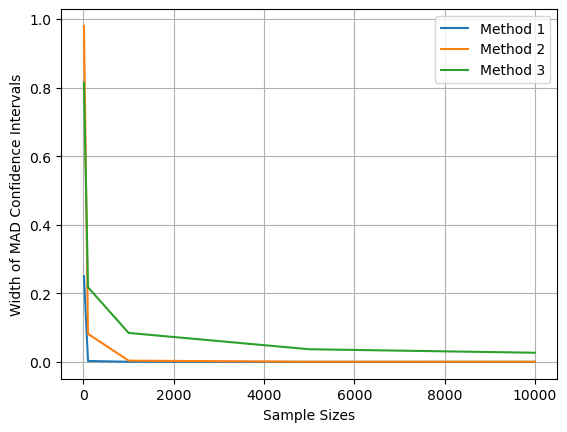

In [4]:
mad_width_method1, mad_width_method2, mad_width_method3 = [], [], []
sample_sizes = [10, 100, 1000, 5000, 10000]

for size in sample_sizes:
    sample = generate_normal_sample(size)

    lower, upper = confidence_interval_mad_method1(sample)
    mad_width_method1.append((upper - lower))

    lower, upper = confidence_interval_mad_method2(sample)
    mad_width_method2.append((upper - lower))

    lower, upper = confidence_interval_mad_method3(sample)
    mad_width_method3.append((upper - lower))

# Plotting the results
plt.plot(sample_sizes, mad_width_method1, label='Method 1')
plt.plot(sample_sizes, mad_width_method2, label='Method 2')
plt.plot(sample_sizes, mad_width_method3, label='Method 3')

plt.xlabel('Sample Sizes')
plt.ylabel('Width of MAD Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

Задание №2

In [5]:
def calculate_minimum_sample_size(sigma, delta, alpha=0.95):
    return np.ceil((sigma ** 2 * (norm.ppf((1 + alpha) / 2) ** 2)) / (delta ** 2))

# Delta values to test
delta_values = [10**-i for i in range(1, 7)]

# Define distributions and their corresponding sigma values
distributions = {
    'Normal Distribution': 1,
    'Uniform Distribution': (1/12) * (1 - 0)**2,
    'Sum of Two Uniform Distributions': (1/12) * (1 - 0)**2 * 2,
    'Cauchy Distribution': 1000
}

# Loop through each distribution and calculate minimum sample sizes
for distribution_name, sigma in distributions.items():
    print(f'\n{distribution_name}')
    for delta in delta_values:
        minimum_sample_size = calculate_minimum_sample_size(sigma, delta)
        print(f'delta = {delta}: min size = {int(minimum_sample_size)}')



Normal Distribution
delta = 0.1: min size = 385
delta = 0.01: min size = 38415
delta = 0.001: min size = 3841459
delta = 0.0001: min size = 384145883
delta = 1e-05: min size = 38414588207
delta = 1e-06: min size = 3841458820695

Uniform Distribution
delta = 0.1: min size = 3
delta = 0.01: min size = 267
delta = 0.001: min size = 26677
delta = 0.0001: min size = 2667680
delta = 1e-05: min size = 266767974
delta = 1e-06: min size = 26676797366

Sum of Two Uniform Distributions
delta = 0.1: min size = 11
delta = 0.01: min size = 1068
delta = 0.001: min size = 106708
delta = 0.0001: min size = 10670719
delta = 1e-05: min size = 1067071895
delta = 1e-06: min size = 106707189464

Cauchy Distribution
delta = 0.1: min size = 384145883
delta = 0.01: min size = 38414588207
delta = 0.001: min size = 3841458820695
delta = 0.0001: min size = 384145882069413
delta = 1e-05: min size = 38414588206941248
delta = 1e-06: min size = 3841458820694125568


Задание №3

In [6]:
def generate_sample_data(sample_size, distribution_type='normal', mean=0, std_dev=1, lower_bound=0, upper_bound=1, count=3):
    if distribution_type == 'normal':
        return [random.gauss(mean, std_dev) for _ in range(sample_size)]
    elif distribution_type == 'uniform':
        return [random.uniform(lower_bound, upper_bound) for _ in range(sample_size)]
    elif distribution_type == 'sum_uniform':
        return [sum(random.uniform(lower_bound, upper_bound) for _ in range(count)) for _ in range(sample_size)]

def calculate_required_sample_size(delta, confidence_level=0.95, min_sample_size=5, distribution_type='normal', **kwargs):
    sigma_estimates = []
    current_sample_size = min_sample_size

    for _ in range(3):
        sample_data = generate_sample_data(current_sample_size, distribution_type, **kwargs)

        sigma_estimate = np.std(sample_data, ddof=1)

        lower_bound = (sigma_estimate * np.sqrt(current_sample_size - 1)) / np.sqrt(chi2.ppf((1 + confidence_level) / 2, current_sample_size - 1))
        upper_bound = (sigma_estimate * np.sqrt(current_sample_size - 1)) / np.sqrt(chi2.ppf((1 - confidence_level) / 2, current_sample_size - 1))

        current_sample_size = np.ceil((sigma_estimate ** 2 * (norm.ppf((1 + confidence_level) / 2) ** 2) / (delta ** 2))).astype(int)

        sigma_estimates.append((lower_bound, upper_bound, current_sample_size))

    upper_bound_sample_size = np.ceil((upper_bound ** 2 * (norm.ppf((1 + confidence_level) / 2) ** 2) / (delta ** 2))).astype(int)

    return sigma_estimates, upper_bound_sample_size

In [7]:
delta_values = [0.1, 0.01, 0.001]
distribution_types = ['normal', 'uniform', 'sum_uniform']
confidence_level = 0.95

for delta in delta_values:
    print(f"delta = {delta}:\n")
    for distribution in distribution_types:
        sigma_estimates, upper_bound_sample_size = calculate_required_sample_size(delta, distribution_type=distribution)
        print(f"\nDistr: {distribution.capitalize()}")
        for lower, upper, sample_size in sigma_estimates:
            print(f"ci: [{lower:.4f}, {upper:.4f}], sample size: {int(sample_size)}")
        print(f"sample size: {int(upper_bound_sample_size)}")


delta = 0.1:


Distr: Normal
ci: [0.5486, 2.6310], sample size: 323
ci: [0.8512, 0.9937], sample size: 323
ci: [0.9291, 1.0846], sample size: 385
sample size: 452

Distr: Uniform
ci: [0.1896, 0.9094], sample size: 39
ci: [0.2454, 0.3871], sample size: 35
ci: [0.2507, 0.4061], sample size: 37
sample size: 64

Distr: Sum_uniform
ci: [0.1953, 0.9365], sample size: 41
ci: [0.4146, 0.6461], sample size: 98
ci: [0.4236, 0.5621], sample size: 90
sample size: 122
delta = 0.01:


Distr: Normal
ci: [0.4044, 1.9395], sample size: 17501
ci: [0.9814, 1.0022], sample size: 37780
ci: [0.9887, 1.0029], sample size: 38086
sample size: 38635

Distr: Uniform
ci: [0.1968, 0.9438], sample size: 4145
ci: [0.2816, 0.2940], sample size: 3180
ci: [0.2807, 0.2949], sample size: 3179
sample size: 3341

Distr: Sum_uniform
ci: [0.2764, 1.3259], sample size: 8179
ci: [0.4928, 0.5081], sample size: 9616
ci: [0.4963, 0.5105], sample size: 9731
sample size: 10012
delta = 0.001:


Distr: Normal
ci: [1.2853, 6.1646], sa